In [1]:
### Load the necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import minimize
from pysr import *
import pickle

plt.rc('text',usetex=True)
plt.rc('font',family='serif',size=14)

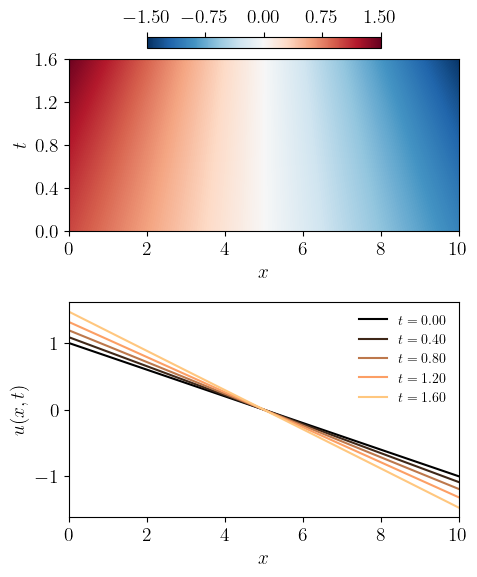

In [2]:
### Load data

with open('Burgers_params.pkl', 'rb') as file:
    data = pickle.load(file)

x = data['x']
t = data['t']
u = data['u']
    
# Plot
fig, ax = plt.subplots(2,1,figsize=(5,6))

contour = ax[0].contourf(x,t,u.T,levels=np.linspace(-1.5,1.5,256),cmap='RdBu_r')
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$t$')
ax[0].set_yticks([0,0.4,0.8,1.2,1.6])
cbar = plt.colorbar(contour, ax=ax[0], location='top', shrink=0.6)
cbar.ax.locator_params(nbins=5)
cbar.set_ticks([-1.5,-0.75,0,0.75,1.5])

color_map = cm.get_cmap('copper', len(x))
for i in range(len(t)):
    color = color_map(i / (len(t) - 1))
    ax[1].plot(x, u[:,i], label=f"$t={t[i]:.2f}$", color=color)
ax[1].set_xlim([np.min(x),np.max(x)])    
ax[1].legend(frameon=False,fontsize=10)
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$u(x,t)$')

plt.tight_layout()
plt.show()

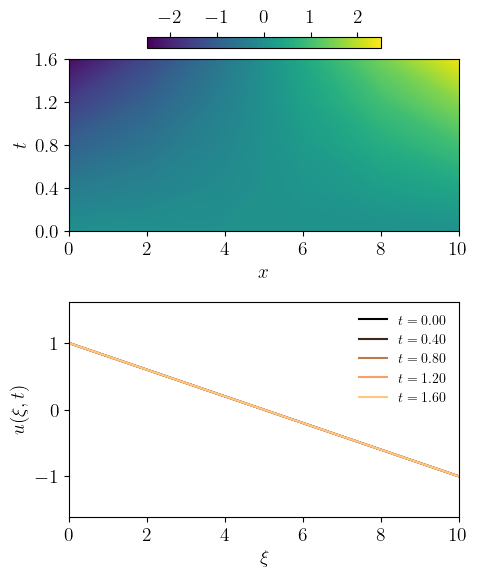

In [3]:
### Theoretical scaling (xi=x-ut)

ut = -u*t
xi = x[:,np.newaxis] + ut

# Plot
fig, ax = plt.subplots(2,1,figsize=(5,6))

contour = ax[0].contourf(x,t,ut.T,levels=np.linspace(-2.5,2.5,256))
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$t$')
cbar = plt.colorbar(contour, ax=ax[0], location='top', shrink=0.6)
cbar.set_ticks([-2,-1,0,1,2])
ax[0].set_yticks([0,0.4,0.8,1.2,1.6])

for i in range(len(t)):
    color = color_map(i / (len(t) - 1))
    ax[1].plot(xi[:,i], u[:,i], label=f"$t={t[i]:.2f}$", color=color)
ax[1].set_xlim([np.min(x),np.max(x)])  
ax[1].legend(frameon=False, fontsize=10)
ax[1].set_xlabel(r'$\xi$')
ax[1].set_ylabel(r'$u(\xi,t)$')  

plt.tight_layout()
plt.show()

In [4]:
### Collapse the profiles

def loss(var, xin, yin):
    vari = np.reshape(var,(len(x),len(t)-1))
    xprime = xin.copy()
    xprime[:,1:] = xprime[:,1:] + vari    
    uprime = yin.copy()
    
    # interpolate at the transformed coordinates grid
    ninterp = len(x)
    llim    = np.max(np.amin(xprime,axis=0))
    ulim    = np.min(np.amax(xprime,axis=0))
    newgr   = np.linspace(llim,ulim,ninterp)
    new_y   = np.zeros((ninterp,np.size(t)))
    for j in range(np.size(t)):
        new_y[:,j] = np.interp(newgr, xprime[:,j], uprime[:,j])
    
    # compute distances
    dist_mat = np.zeros((len(t)))
    for i in range(len(t)):
        dist_mat[i] = (np.linalg.norm(new_y[:,i] - new_y[:,0]))**2
        
    dist = np.sum(dist_mat)
                     
    return dist

# Optimisation
niter = 20
fmin  = 1e20
for i in range(niter):
    varopt = np.zeros((len(x),len(t)-1))
    for i in range(len(t)-1):
        varopt[:,i] = varopt[:,i] + (np.random.rand(np.size(x))-1)*1
    varopt = varopt.flatten()
    
    res = minimize(loss, varopt, args=(np.tile(x[:,np.newaxis],(1,len(t))), u))

    if (res.fun < fmin):
        fmin  = res.fun
        var_b = res.x

varm = np.reshape(var_b,(len(x),len(t)-1))
xprime = (np.tile(x[:,np.newaxis],(1,len(t)))).copy()
xprime[:,1:] = xprime[:,1:] + varm  
utfound = varm
utfound = np.insert(utfound, 0, ut[:,0], axis=1)

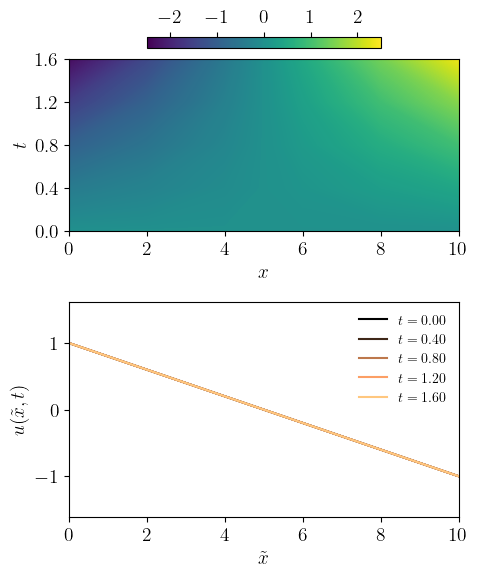

In [5]:
### Plot data

fig, ax = plt.subplots(2,1,figsize=(5,6))

contour = ax[0].contourf(x,t,utfound.T,levels=np.linspace(-2.5,2.5,256))
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$t$')
cbar = plt.colorbar(contour, ax=ax[0], location='top', shrink=0.6)
cbar.set_ticks([-2,-1,0,1,2])
ax[0].set_yticks([0,0.4,0.8,1.2,1.6])

color_map = cm.get_cmap('copper', len(x))
for i in range(len(t)-0):
    color = color_map(i / (len(t) - 1))
    ax[1].plot(xprime[:,i], u[:,i], label=f"$t={t[i]:.2f}$", color=color)
ax[1].set_xlim([np.min(x),np.max(x)])  
ax[1].legend(frameon=False, fontsize=10)
ax[1].set_xlabel(r'$\tilde{x}$')
ax[1].set_ylabel(r'$u(\tilde{x},t)$')  

plt.tight_layout()
plt.show()

In [6]:
### Interpret transformation

mat1 = np.ndarray.flatten(u[:,1:])
mat2 = np.tile(t[1:],len(x))
mat3 = np.repeat(x,np.size(t)-1)
Xsr  = np.array([mat1, mat2, mat3]).T
X_dims = ["m/s", "s", "m"]

Ysr = np.ndarray.flatten(varm)
Y_dims = ["m"]

model = PySRRegressor(
    model_selection='best',
    binary_operators=["+","-","*","/"],
    unary_operators=[],
    dimensional_constraint_penalty=10**5,
    complexity_of_constants=4,
    complexity_of_variables=1
    )
model.fit(Xsr, Ysr, X_units = X_dims, y_units = Y_dims)

/home/nikos/.local/lib/python3.10/site-packages/pysr/sr.py:1346: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


/home/nikos/.local/lib/python3.10/site-packages/julia/juliainfo.py:93: UserWarning: julia warned:
The latest version of Julia in the `alpha` channel is 1.10.1+0.x64.linux.gnu. You currently have `1.10.0-beta2+0.x64.linux.gnu` installed. Run:

  juliaup update

to install Julia 1.10.1+0.x64.linux.gnu and update the `alpha` channel to that version.
  warnings.warn("{} warned:\n{}".format(julia, stderr))
/home/nikos/.local/lib/python3.10/site-packages/julia/juliainfo.py:93: UserWarning: julia warned:
The latest version of Julia in the `alpha` channel is 1.10.1+0.x64.linux.gnu. You currently have `1.10.0-beta2+0.x64.linux.gnu` installed. Run:

  juliaup update

to install Julia 1.10.1+0.x64.linux.gnu and update the `alpha` channel to that version.
  warnings.warn("{} warned:\n{}".format(julia, stderr))
/home/nikos/.local/lib/python3.10/site-packages/julia/juliainfo.py:93: UserWarning: julia warned:
The latest version of Julia in the `alpha` channel is 1.10.1+0.x64.linux.gnu. You currently 

Started!

Expressions evaluated per second: 2.180e+05
Head worker occupation: 37.8%. This is high, and will prevent efficient resource usage. Increase `ncyclesperiteration` to reduce load on head worker.
Progress: 560 / 600 total iterations (93.333%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           3.153e+01  1.594e+01  y[m] = x₂[m]
3           1.064e+00  1.694e+00  y[m] = (x₂[m] - x₂[m])
6           8.020e-01  9.437e-02  y[m] = (x₂[m] * 0.083505[⋅])
7           2.955e-08  1.567e+01  y[m] = ((x₂[m] - (x₀[m s⁻¹] * x₁[s])) - x₂[m])
9           2.955e-08  1.294e-04  y[m] = ((x₀[m s⁻¹] * x₁[s]) - ((x₀[m s⁻¹] + x₀[m s⁻¹]) * x₁[s]...
                                  ))
15          2.351e-08  3.805e-02  y[m] = ((((x₁[s] * -2.741[⋅]) + x₁[s]) * 0.57435[⋅]) * x₀[m s⁻...
                                  ¹])
----------------------------------------------------------------------

PySRRegressor.equations_ = [
	   pick      score                                        equation   
	0         0.000000                                              x2  \
	1         1.694169                                       (x2 - x2)   
	2         0.094366                               (x2 * 0.08350507)   
	3  >>>>  17.116465                         ((x2 - (x0 * x1)) - x2)   
	4         0.000129                  ((x0 * x1) - ((x0 + x0) * x1))   
	5         0.038049  ((((x1 * -2.7409723) + x1) * 0.57434845) * x0)   
	
	           loss  complexity  
	0  3.152635e+01           1  
	1  1.064478e+00           3  
	2  8.020263e-01           6  
	3  2.955305e-08           7  
	4  2.954540e-08           9  
	5  2.351491e-08          15  
]

In [7]:
model.sympy()

-x0*x1